Скачивание датасета с google диска, чтобы каждый раз не загружать его с kaggle


In [11]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/kaggle.json" /content/
!chmod 600 kaggle.json
!cp "/content/drive/MyDrive/archive.zip" /content/
!unzip /content/archive.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/archive.zip
replace ddata/test/fake/fake_041594.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Глобальные переменные, которые удобнее вынести


In [12]:
EPOCHS = 3 # количество проходов модели по датасету
BATCH_SIZE = 32  # для того чтобы оперативная память не занималась всеми картинками, а загружалась группами по 32

Импорт библиотек


In [13]:
!pip install split-folders
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.model_selection import train_test_split
import splitfolders
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Загрузка и предпросмотр данных


Copying files: 21776 files [00:17, 1238.35 files/s]


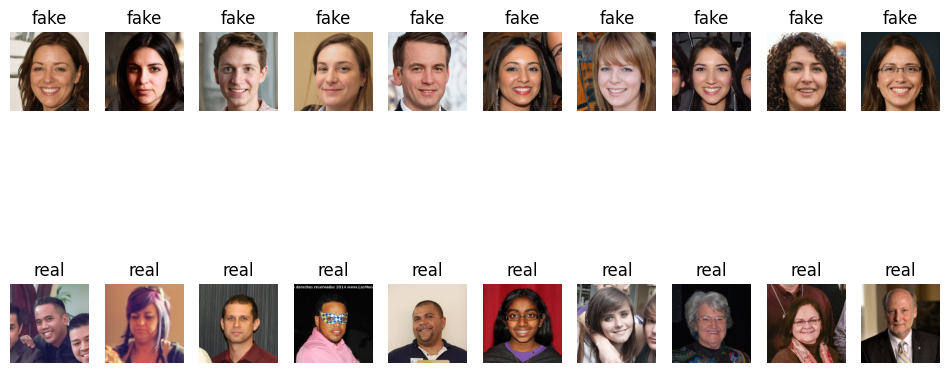

In [14]:

dataset = 'ddata/test' #загружаем только данные из test, так как там достаточно картинок
output_folder = 'ml-dataset'
splitfolders.ratio(
    dataset,
    output=output_folder,
    seed=1337,
    ratio=(0.7, 0.1, 0.2),
    group_prefix=None
) # разделяем картинки в другом порядке, чтобы в дальнейшем обучить по ним модель
categories = ['fake', 'real']
exam_imgs = []
for i in categories:
  class_path = os.path.join(dataset, i)
  images = []
  for img in os.listdir(class_path):
    if img.endswith(('.png', '.jpg', '.jpeg')):
      images.append(img)
  for x in images[:10]:
    img_p = os.path.join(class_path, x)
    exam_imgs.append((img_p, i))

fig, axes = plt.subplots(2, 10, figsize=(12, 6))
for i, (img_path, label) in enumerate(exam_imgs):
  img = load_img(img_path)
  ax = axes[i // 10, i % 10]
  ax.imshow(img)
  ax.set_title(label)
  ax.axis("off")
plt.show()

Создаем генераторы для нашей модели



In [15]:


# аугментация только для train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# для val и test — только нормализация, без аугментации
val_test_datagen = ImageDataGenerator(rescale=1./255)

# пути к новым папкам
train_dir = 'ml-dataset/train/'
val_dir = 'ml-dataset/val/'
test_dir = 'ml-dataset/test/'

# train-generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Для multi-class (fake/real — это два, но если больше, ок)
    shuffle=True
)

# val-generator
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# test-generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 15242 images belonging to 2 classes.
Found 2176 images belonging to 2 classes.
Found 4358 images belonging to 2 classes.


Создание и обучение модели

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
476/476 ━━━━━━━━━━━━━━━━━━━━ 100s 198ms/step - accuracy: 0.6544 - loss: 0.6219 - val_accuracy: 0.8791 - val_loss: 0.3618
Epoch 2/3
  1/476 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7500 - loss: 0.4990

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


476/476 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7500 - loss: 0.4990 - val_accuracy: 0.8575 - val_loss: 0.3811
Epoch 3/3
476/476 ━━━━━━━━━━━━━━━━━━━━ 90s 189ms/step - accuracy: 0.8330 - loss: 0.4052 - val_accuracy: 0.9099 - val_loss: 0.2574


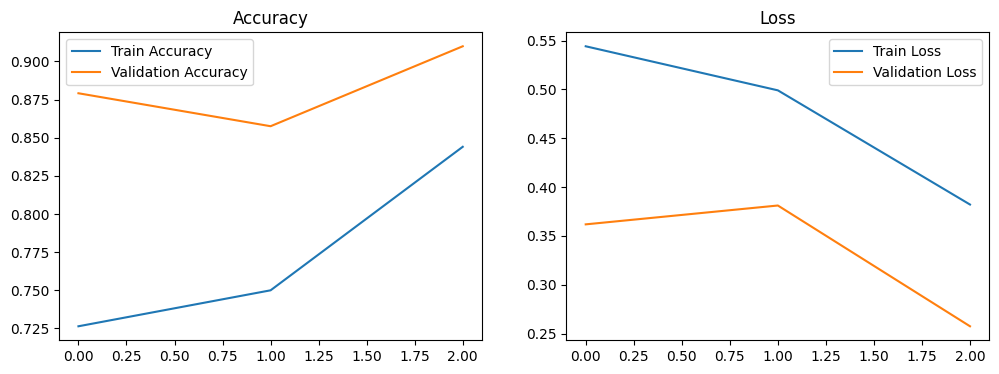

In [16]:
# создаем модель CNN для анализа наших изображений
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
#обучаем модель
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    verbose=1
)
#выводим результаты обучения модели
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()

In [17]:
#тестируем ее на наших тестовых данных
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')


137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9553 - loss: 0.1450
Test accuracy: 0.9217531085014343


In [25]:
#код для проверки на дипфейк нужного изображения
def prepare_image(img_path, target_size=(128, 128)):

    img = image.load_img(img_path, target_size=target_size)

    img_array = image.img_to_array(img) / 255.0

    img_array = np.expand_dims(img_array, axis=0)
    return img_array

img_path = '/content/ml-dataset/test/real/real_045615.jpg'
prepared_img = prepare_image(img_path)
predictions = model.predict(prepared_img)
print("вероятности на то что изображение дипфейк/реальное:", predictions)


predicted_class_idx = np.argmax(predictions, axis=-1)


class_labels = ['fake', 'real']
predicted_class_name = class_labels[predicted_class_idx[0]]
print(f"предсказанный класс изображения: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
вероятности на то что изображение дипфейк/реальное: [[0.03196461 0.96803534]]
предсказанный класс изображения: real
